# Naive Bayes Implementaion on MNIST dataset

Here is the process
1. Data processing 
2. Feature extraction
3. Training with Naive Bayes classification algorithm
4. Testing 
5. showing result

In [20]:
import numpy as np
from collections import Counter,defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure

file_path = "..\\train-images-idx3-ubyte\\train-images.idx3-ubyte"
file_path2 = "..\\train-labels-idx1-ubyte\\train-labels.idx1-ubyte"
with open(file_path, 'rb') as file:
    data = file.read()
with open(file_path2, 'rb') as file:
    data_label = file.read()

# Extract the header information
magic_number = int.from_bytes(data[:4], 'big')
num_images = int.from_bytes(data[4:8], 'big')
num_rows = int.from_bytes(data[8:12], 'big')
num_cols = int.from_bytes(data[12:16], 'big')

# Extract the image data
images = np.frombuffer(data[16:], dtype=np.uint8)
images = images.reshape(num_images, num_rows, num_cols)

#extracting the labels
labels = np.frombuffer(data_label[8:],dtype=np.uint8)


image_train = images[:int(0.8*len(images))]
image_test = images[int(0.8*len(images)):]

labels_train = labels[:int(0.8*len(images))]
labels_test = labels[int(0.8*len(images)):]


# print(images.shape, labels.shape)

(48000, 28, 28) (48000,)


# Featurizing...
1 Raw pixel intensities

In [21]:

def feature1():
    pixels = image_train.shape[1] * image_train.shape[2]
    fl_ima_train = image_train.reshape(image_train.shape[0],pixels)
    f1_ima_test = image_test.reshape(image_test.shape[0],pixels)
    return fl_ima_train/255.0, f1_ima_test/255.0

# f1,f2 = feature1()
# f1.shape

2. Histogram of Oriented Gradients (HOG)

In [22]:
def feature2():
    hog_features_train = []
    for image in image_train:
        # Compute HOG features
        # hog()
        fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True)
        hog_features_train.append(fd)

    hog_features_test = []
    for image in image_test:
        # Compute HOG features
        fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True)
        hog_features_test.append(fd)

    # Convert the HOG feature lists to arrays
    hog_features_train = np.array(hog_features_train)
    hog_features_test = np.array(hog_features_test)
    return  hog_features_train,hog_features_test



# Naive Bayes

In [24]:
# Naive Bayes implementaion
def prior():
    p = Counter(labels_train)
    prior_dict = defaultdict()
    for i in p:
        prior_dict[i] = p[i]/len(labels_train)
    return prior_dict


def train(laplace_smoothing):

    image_train = feature1()[0]
    c = Counter(labels_train)
    train_dict = {j:np.array([laplace_smoothing]*image_train.shape[1]) for j in c}

    
    # print(train_dict)

    for i in range(len(image_train)):
        label = labels_train[i]
        # updating train_dict by label
        train_dict[label] = [x + y for x,y in zip(train_dict[label],image_train[i])]

    # print(train_dict)
    for i in train_dict:
        train_dict[i] = np.array([np.log(n/c[i]) for n in train_dict[i]])

    
    return train_dict

# prior()
# train()

# Testing

In [25]:
model = train(0.0000000000001)
prior = prior()
def test(model):
    # Prepare the test data
    image_test = feature1()[1]
    # labels_test = labels_test

    # Predict the labels
    predictions = []
    for i in range(len(image_test)):
        label_probs = {}
        for label in model:
            label_probs[label] = np.sum((model[label] * image_test[i])) + prior[label]
        predicted_label = max(label_probs, key=label_probs.get)
        predictions.append(predicted_label)

    # Evaluate the performance
    accuracy = np.mean(np.array(predictions) == labels_test)

    return accuracy
test(model)


0.70675

# Data representation

In [26]:
dataS = {
    'Laplace Smoothing': [1,0.5,0.2,0.0001,0.0000001],
    'Accuracy': [0.7038333333333333,0.70425,0.7046666666666667,0.70575,0.7064166666666667],

} ## data collected by experimenting with different laplace smoothings...
df = pd.DataFrame(dataS)
df

,Laplace Smoothing,Accuracy
0,1.000000e+00,0.703833
1,5.000000e-01,0.704250
2,2.000000e-01,0.704667
3,1.000000e-04,0.705750
4,1.000000e-07,0.706417


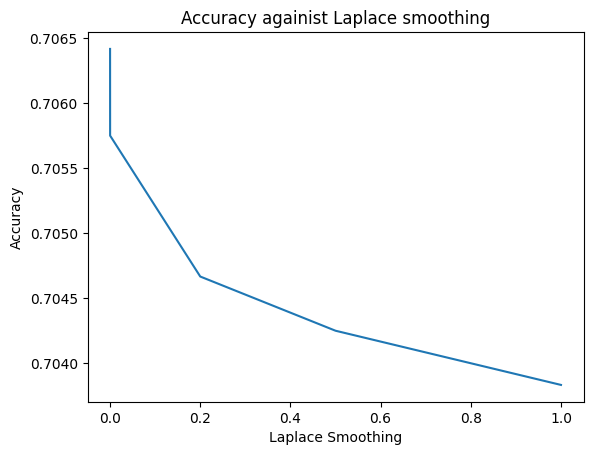

In [30]:
plt.plot(dataS['Laplace Smoothing'],dataS['Accuracy'])
plt.title("Accuracy againist Laplace smoothing")
plt.xlabel("Laplace Smoothing")
plt.ylabel("Accuracy")
plt.show()   